In [2]:
# Try changepoint detection algorithm instead of unit root test in step1

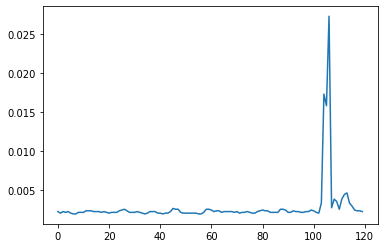

In [2]:
import sys

sys.path.append('../')
from tsdr import tsdr

import matplotlib.pyplot as plt
import numpy as np

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
misdetected_series = data_df['s-user_latency'].to_numpy()
plt.plot(misdetected_series)

(<Figure size 576x288 with 1 Axes>, [<AxesSubplot:>])

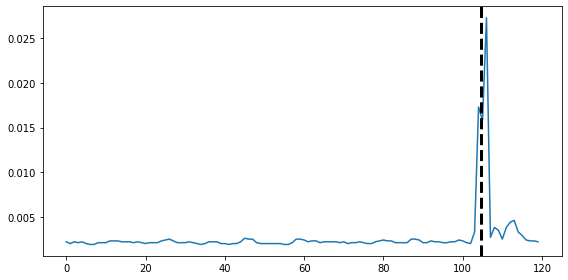

In [4]:
import ruptures as rpt

algo = rpt.Binseg(model='ar').fit(misdetected_series)
bkps = algo.predict(n_bkps=None, pen=0.0001)
rpt.show.display(misdetected_series, [], bkps, figsize=(8, 4))

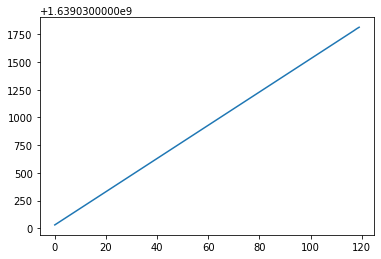

In [5]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user-db_pod-cpu-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
liner_series = data_df['c-catalogue_last_seen'].to_numpy()
plt.plot(liner_series)

(<Figure size 576x288 with 1 Axes>, [<AxesSubplot:>])

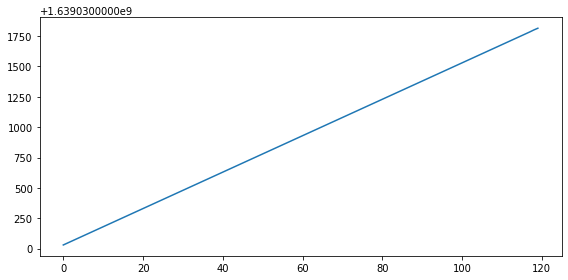

In [6]:
import ruptures as rpt

algo = rpt.Binseg(model='ar').fit(liner_series)
bkps = algo.predict(pen=10)
rpt.show.display(liner_series, [], bkps, figsize=(8, 4))

In [7]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid, breaks_hansen

_, pvalue, _ = breaks_cusumolsresid(misdetected_series)
print(f"{pvalue:.10f}")

_, pvalue, _ = breaks_cusumolsresid(liner_series)
print(f"{pvalue:.10f}")


breaks_hansen(misdetected_series)

0.0000000000
0.0000000000


AttributeError: 'numpy.ndarray' object has no attribute 'model'

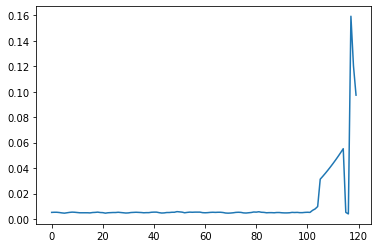

In [3]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-carts_pod-memory-hog_4.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
misdetected_series2 = data_df['s-carts_latency'].to_numpy()
plt.plot(misdetected_series2)

In [12]:
import numpy as np 
import numpy.typing
import functools

class KNNOutlierDetector:
    w: int = 0
    k: int = 1

    def __init__(self, w: int, k: int) -> None:
        self.w = w        
        self.k = k
    
    def score(self, data: np.ndarray):
        windows: list[np.ndarray] = self.sliding_windows(data) 
        scores: list[float] = []
        for t in range(len(windows)):
            distances: list[float] = []
            for window in windows:
                distances.append(self.dist(windows[t], window))
            distances.sort()
            s: float = functools.reduce(lambda x, y: x+y, distances[1:self.k+1], 0.0) / self.k
            scores.append(s)
        # Adjust the size of input/output list
        return [0.0] * (self.w-1) + scores
    
    def sliding_windows(self, data: np.ndarray) -> list[np.ndarray]:
        num: int = data.size - self.w + 1
        return [data[t:t+self.w] for t in range(num)]
    
    def dist(self, v1: np.ndarray, v2: np.ndarray) -> float:
        sum: float = 0.0
        for i, v in enumerate(v1):
            sum += (v - v2[i]) ** 2
        return np.sqrt(sum)

In [13]:
knn = KNNOutlierDetector(2, 1)
data = np.array([1, 2, 10, 2, 1])
knn.score(data)

[0.0,
 1.4142135623730951,
 8.06225774829855,
 8.06225774829855,
 1.4142135623730951]

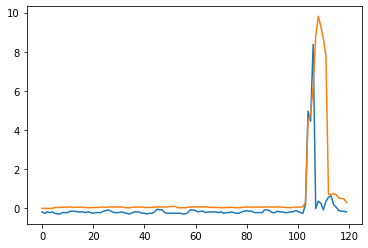

In [31]:
import scipy.stats

zscores = scipy.stats.zscore(misdetected_series)
plt.plot(zscores)
knn = KNNOutlierDetector(int(misdetected_series.size * 0.05), 1)
scores = knn.score(zscores)
plt.plot(scores)

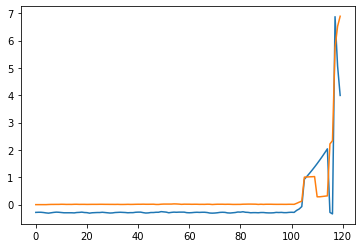

In [29]:
knn = KNNOutlierDetector(int(misdetected_series2.size * 0.05), 1)
scores2 = knn.score(misdetected_series2)
plt.plot(scores2)

array([ 86.8978, 120.0454, 130.3337, 155.1289, 154.5636, 152.1516,
       132.5102, 132.4632, 107.0381, 118.4081, 107.1694,  99.7671,
       124.3743, 128.2224, 139.9703, 125.7366,  92.3745,  89.6453,
       102.6375,  78.8806, 103.0238, 116.646 , 104.7384, 124.9676,
       135.5366, 134.8494, 139.3335, 134.3233, 137.5058, 146.99  ,
       141.3216, 107.2515, 127.7063, 126.3019, 126.8437, 129.4861,
       112.4947, 136.9376, 140.4652, 141.6139, 110.2816,  98.1193,
        84.188 , 121.4153, 134.9548, 138.1096, 132.2023, 113.6855,
       137.3913,  91.581 , 124.7202, 119.1257, 104.0989, 128.7707,
       112.8108, 138.9598, 129.0233, 139.4876, 127.0471, 101.7903,
       136.9381, 141.6726, 136.9517, 122.0967, 105.7711, 110.3874,
       112.5925, 125.0574, 122.7304, 134.0018, 108.6104, 138.5027,
       140.6871, 115.9734, 154.4489, 151.232 , 104.3202, 134.6571,
       134.1664, 100.8984, 125.712 , 123.2046, 132.0699, 119.5612,
        80.4539, 102.4304, 104.0508, 106.2587, 118.242 ,  74.4

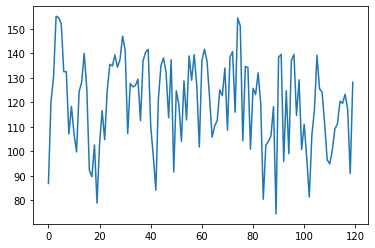

In [17]:
# White-noise
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-cpu-hog_2.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
white_noise_series = data_df['c-orders_network_receive_packets_total'].to_numpy()
plt.plot(white_noise_series)
white_noise_series

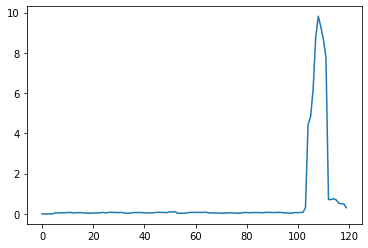

In [32]:
zscores = scipy.stats.zscore(white_noise_series)
knn = KNNOutlierDetector(6, 1)
wn_scores = knn.score(zscores)
plt.plot(wn_scores)

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


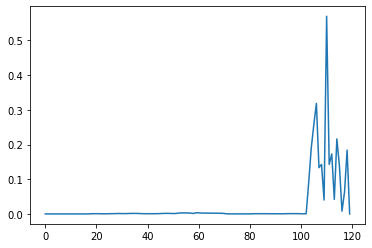

In [ ]:
import banpei

sst = banpei.SST(w=int(misdetected_series.size * 0.1))
results = sst.detect(misdetected_series, is_lanczos=True)
plt.plot(results)

(-3.2307942150246762, 0.07843836025512022, 4, 115, {'1%': -4.039730383003206, '5%': -3.4493804768636473, '10%': -3.1498449798635657}, 25.179022021428352)


Test Statistic,-4.596
P-value,0.001
Lags,13


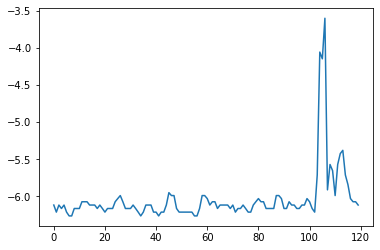

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

# ar = AutoReg(misdetected_series, lags=None)
# ar_fit = ar.fit()
# lags = ar_fit.ar_lags()
# coef = ar_fit.params
import arch.unitroot

print(adfuller(np.log(misdetected_series), regression='ct'))
plt.plot(np.log(misdetected_series))
arch.unitroot.PhillipsPerron(np.log(misdetected_series), trend='ct')

In [ ]:
model = AR(misdetected_series)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

for index, test in enumerate(misdetected_series):
